<a href="https://colab.research.google.com/github/felipedoamarals/Aceleracao_Global_Dev4_Everis/blob/master/Live%20%237.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Live #7 - Trabalhando com serviços de mensageria real time com Python e Kafka na prática

Profº [**Hugo de Oliveira Alves**](https://www.linkedin.com/in/huguinho/) <br>


### 1 - Introdução a micro serviços
Micro Serviços
- Arquitetura Monolítica: Banco + aplicação no mesmo servidor;
- Arquitetura micro serviços: Aplicação dividida em módulos em servidores diferentes;
- Micro serviços: Desvantagens
  - Centralizar log's
  - Comunicação gerando acoplamento entre módulos



### 2 - [Mensageria](https://medium.com/@devbrito91/01-clean-code-d544d4e8cc7d)
Mensageria é um conceito que define que sistemas distribuídos, possam se comunicar por meio de troca de mensagens (evento), sendo estas mensagens “gerenciadas” por um Message Broker (servidor/módulo de mensagens)
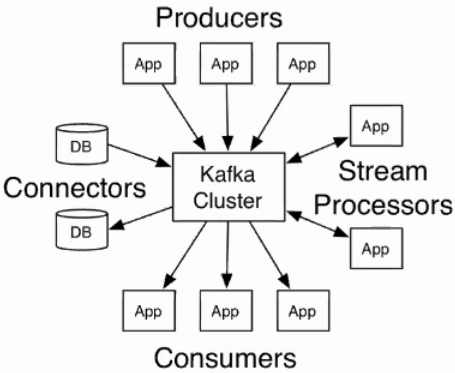

### 3 - [Kafka](https://pt.wikipedia.org/wiki/Apache_Kafka)
É uma plataforma open-source de processamento de streams desenvolvida pela Apache Software Foundation, escrita em Scala e Java.
- Open Source
- Processamento de Streams
- Não precisa reiventar a roda

### 4 - Kafka as a Service
[Karafka Cloud](https://www.cloudkarafka.com/)
- Clusters Kafka gerenciados na nuvem.
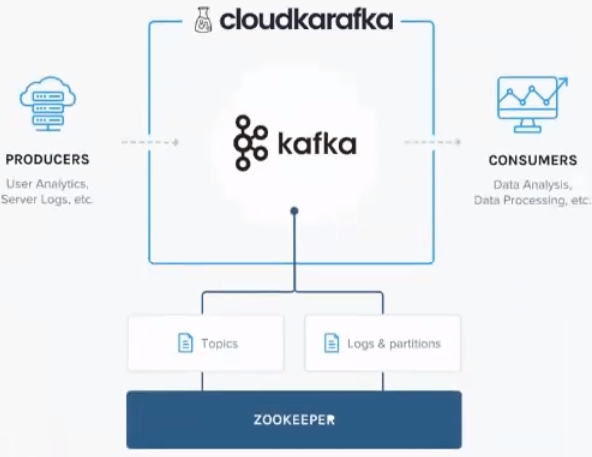

### 5 - Lab - Python + Kafka

5.1 - Producer

In [1]:

#Instalando biblioteca
!pip install confluent_kafka

     |████████████████████████████████| 8.1MB 9.7MB/s 


In [10]:
import sys
import os

from confluent_kafka import Producer

def delivery_callback(err, msg):
    if err:
        print('%% Message failed delivery: %s\n', err)
    else:
        print('%% Message delivered to %s [%d]\n',
                          (msg.topic(), msg.partition()))

def createTopic():
    print("init");
    #topic = '25fi2ymi-topic1'
    topic = '25fi2ymi-default'

    # Consumer configuration
    # See https://github.com/edenhill/librdkafka/blob/master/CONFIGURATION.md
    conf = {
        'bootstrap.servers': 'tricycle-01.srvs.cloudkafka.com:9094,tricycle-02.srvs.cloudkafka.com:9094,tricycle-03.srvs.cloudkafka.com:9094',
        'session.timeout.ms': 6000,
        'default.topic.config': {'auto.offset.reset': 'smallest'},
        'security.protocol': 'SASL_SSL',
	'sasl.mechanisms': 'SCRAM-SHA-256',
        'sasl.username': '25fi2ymi',
        'sasl.password': 'owaqWZ8jve0rsct5yHS3l9xGGK1rIL82'
    }

    p = Producer(conf)

    try:
        p.produce(topic, "my message new 10", callback=delivery_callback)
    except BufferError as e:
        print('%% Local producer queue is full (%d messages awaiting delivery): try again\n',
                          len(p))
    p.poll(0)

    print('%% Waiting for %d deliveries\n' % len(p))
    p.flush()

createTopic();

init
% Waiting for 1 deliveries

%% Message delivered to %s [%d]
 ('25fi2ymi-default', 2)


5.2 Consumer

In [11]:
import sys
import os

from confluent_kafka import Consumer, KafkaException, KafkaError

def createConsumer():

    topics = ['25fi2ymi-default']

    # Consumer configuration
    # See https://github.com/edenhill/librdkafka/blob/master/CONFIGURATION.md
    conf = {
        'bootstrap.servers': 'tricycle-01.srvs.cloudkafka.com:9094,tricycle-02.srvs.cloudkafka.com:9094,tricycle-03.srvs.cloudkafka.com:9094',
        'group.id': "%s-consumer" % '25fi2ymi',
        'session.timeout.ms': 6000,
        'default.topic.config': {'auto.offset.reset': 'smallest'},
        'security.protocol': 'SASL_SSL',
	'sasl.mechanisms': 'SCRAM-SHA-256',
        'sasl.username': '25fi2ymi',
        'sasl.password': 'owaqWZ8jve0rsct5yHS3l9xGGK1rIL82'
    }

    c = Consumer(conf)
    c.subscribe(topics)
    try:
        while True:
            msg = c.poll(timeout=1.0)
            if msg is None:
                continue
            if msg.error():
                # Error or event
                if msg.error().code() == KafkaError._PARTITION_EOF:
                    # End of partition event
                    sys.stderr.write('%% %s [%d] reached end at offset %d\n' %
                                     (msg.topic(), msg.partition(), msg.offset()))
                elif msg.error():
                    # Error
                    raise KafkaException(msg.error())
            else:
                # Proper message
                sys.stderr.write('%% %s [%d] at offset %d with key %s:\n' %
                                 (msg.topic(), msg.partition(), msg.offset(),
                                  str(msg.key())))
                print(msg.value())

    except KeyboardInterrupt:
        sys.stderr.write('%% Aborted by user\n')

    # Close down consumer to commit final offsets.
    c.close()

createConsumer()

% 25fi2ymi-default [0] at offset 15 with key None:


b'my message new 6'


% 25fi2ymi-default [1] at offset 12 with key None:
% 25fi2ymi-default [2] at offset 20 with key None:


b'my message new 6'
b'my message new 10'


%% Aborted by user
